# Benchmarks

Now that you have seen the problem of differential abundance defined, and a formal proof why it should not be analytically possible, let's try to see really how bad this problem can get.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from skbio.stats.composition import closure  # normalizes samples to add to 1.
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# False Positives

We'll first start off simulating environments using a finite urn that is initially uniformly distribution, but the first species in the urn exponentially increases by 5 orders of magnitude. And we'll show shortly how false positives can arise in differential abundance analyses.

In [2]:
D = 1000   # number of species
S = 10     # number of different samples
N = 10000  # sequencing depth
R = 30     # number of replicates
otu_ids = ["O%d"%i for i in range(D)]
sample_ids = ["S%d"%i for i in range(S)]
data = [[1000]*D]
for a in np.logspace(0, 5, S-1):
    data.append([1000*a] + [1000]*(D-1))
table = pd.DataFrame(data, columns=otu_ids, index=sample_ids)

By convention, 30 replicates is enough to tweeze out the difference between two groups of samples.

So we'll do the following - we'll have 30 replicates of sample 1, and compare it to 30 replicates to of sample $i$.  Then we will run a t-test or Mann-Whitney test to see if there is a significant difference.  Since we know a prior which species are changing, we can look at the false positive rate.

In this example, we'll refer to a false positive as a species that is detected to be significantly different according to a statistical test with a pvalue < 0.05

And to simulate a more realistic environment, we'll convert the absolute abundnaes in the environment to probabilities and sample from those probabilities using multinomial sampling.  We're assuming that sequencing depth is not a problem, so all samples will have an equal sequencing depth of 10,000 reads.

In [3]:
fdr = []
for i in range(1, S):
    sample1 = np.random.multinomial(N, closure(table.iloc[0, :].values), size=R)
    sample2 = np.random.multinomial(N, closure(table.iloc[i, :].values), size=R)
    t, p = scipy.stats.ttest_ind(sample1, sample2)
    fdr.append((p[1:]<0.05).sum())

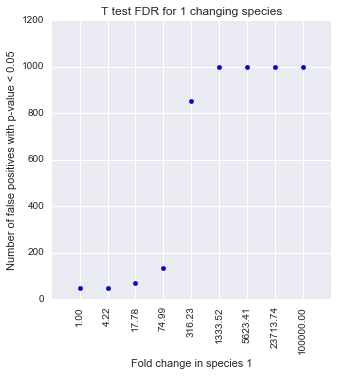

In [4]:
fig = plt.figure(figsize=(5, 5))
x = range(i)
plt.scatter(x, fdr)
labels = np.logspace(0, 5, S-1)
labels = ["%.2f" % a for a in labels]
_ = plt.xticks(x, labels, rotation=90)
plt.ylabel('Number of false positives with p-value < 0.05')
plt.xlabel('Fold change in species 1')
plt.title('T test FDR for 1 changing species')

So here, we have the number of false positives sharply increases when the first species increases by 2 orders of magnitude.  As shown below, the exact same patterns occurs with non-parametric tests such as Mann-Whitney.

In [5]:
fdr = []
for i in range(1, S):
    sample1 = np.random.multinomial(N, closure(table.iloc[0, :].values), size=R)
    sample2 = np.random.multinomial(N, closure(table.iloc[i, :].values), size=R)
    p = np.array([scipy.stats.mannwhitneyu(sample1[:, i], sample2[:, i]).pvalue for i in range(D)])
    fdr.append((p[1:]<0.05).sum())

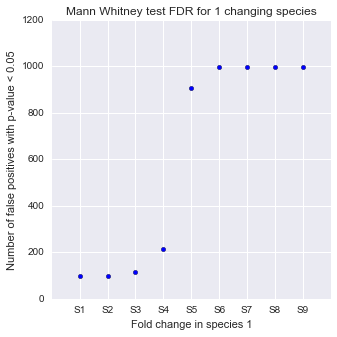

In [6]:
fig = plt.figure(figsize=(5, 5))
x = range(i)
plt.scatter(x, fdr)
_ = plt.xticks(x, sample_ids[1:])
plt.ylabel('Number of false positives with p-value < 0.05')
plt.xlabel('Fold change in species 1')
plt.title('Mann Whitney test FDR for 1 changing species')

And this is a very realistic scenario - blooms do happen frequently.  In fact there was a bloom found in this [paper](http://www.pnas.org/content/113/22/E3130.abstract) that wasn't detected until compositional techniques were applied.

Now, this sceranio can also occur in more nuanced situtations.  Imagine if not just 1 species was increasing but multiple species were increasing.  The exact same phenomenon will occur.  

Here's another way to think about it - if 1 species was increasing by 5 orders of magnitude, it will have the exact same effect as 10 species increasing at 4 orders of magnitude.  

To benchmark this, let's vary the number of significant species.  For now, let's vary the number of species that have doubled.

In [7]:
D = 1000   # number of species
S = 10     # number of different samples
N = 10000  # sequencing depth
R = 30     # number of replicates
M = 500    # maximum number of species changing.
otu_ids = ["O%d"%i for i in range(D)]
sample_ids = ["S%d"%i for i in range(S)]
data = []
for i in range(0, M, 50): # 10 samples, steps of 50
    data.append([2000]*i + [1000]*(D-i))
table = pd.DataFrame(data, columns=otu_ids, index=sample_ids)

In [8]:
fdr = []
for i, a in enumerate(range(50, M, 50)):
    sample1 = np.random.multinomial(N, closure(table.iloc[0, :].values), size=R)
    sample2 = np.random.multinomial(N, closure(table.iloc[i, :].values), size=R)
    p = np.array([scipy.stats.mannwhitneyu(sample1[:, i], sample2[:, i]).pvalue for i in range(D)])
    fdr.append((p[a:]<0.05).sum()) 

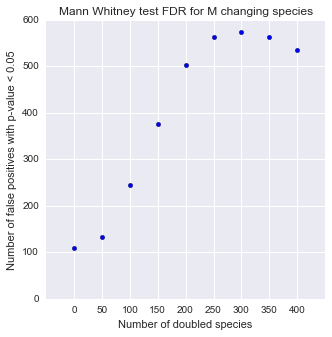

In [9]:
fig = plt.figure(figsize=(5, 5))
x = range(S-1) 
plt.scatter(x, fdr)
labels = range(0, M, 50)
_ = plt.xticks(x, labels)
plt.ylabel('Number of false positives with p-value < 0.05')
plt.xlabel('Number of doubled species')
plt.title('Mann Whitney test FDR for M changing species')

Definitely see a very similar pattern here.  The number of false positives increases as the number of signficantly changing species increases.  We'll show shortly that the problems associated with compositional data not only give rise to false positives, but also false negatives.


# False Negatives

Say that you have 1 very dominant species.  Overwhelms everything else in the community.  What will happen then?
Let's simulate an environment with 1 species that is 1000x higher than everything else.  And another species with lower abundance that will bloom exponentially.

In [10]:
D = 1000   # number of species
S = 10     # number of different samples
N = 10000  # sequencing depth
R = 30     # number of replicates
otu_ids = ["O%d"%i for i in range(D)]
sample_ids = ["S%d"%i for i in range(S)]
data = [[1000]*D]
for a in np.logspace(0, 5, S-1):
    # First species blooms.  Second species is high abundance.  
    # Everything else is uniformly distributed.
    data.append([1000*a] + [1000*1000]  + [1000]*(D-2))
table = pd.DataFrame(data, columns=otu_ids, index=sample_ids)

In [11]:
pvals = []
for i in range(1, S):
    sample1 = np.random.multinomial(N, closure(table.iloc[0, :].values), size=R)
    sample2 = np.random.multinomial(N, closure(table.iloc[i, :].values), size=R)
    p = np.array([scipy.stats.mannwhitneyu(sample1[:, i], sample2[:, i]).pvalue for i in range(D)])
    pvals.append(p)
pvals = np.vstack(pvals)

In [12]:
pvals = pd.DataFrame(pvals, columns=otu_ids, index=sample_ids[1:])

Using the same procedure as before, let try to just visualize the p-values.

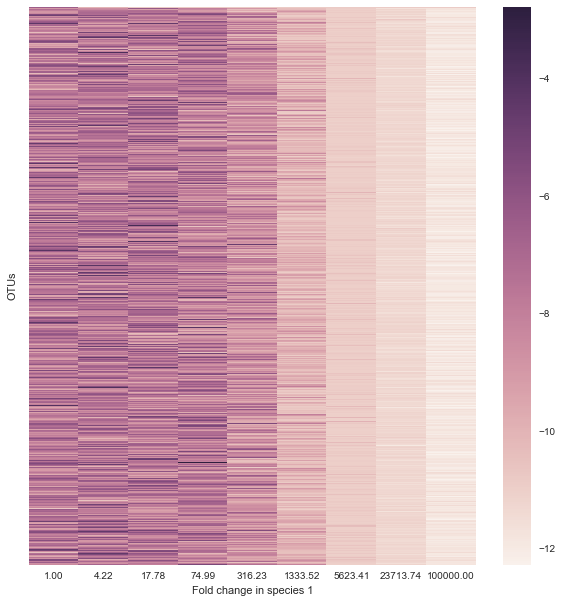

In [13]:
fig = plt.figure(figsize=(10, 10))

labels = np.logspace(0, 5, S-1)
labels = ["%.2f" % a for a in labels]
ax = sns.heatmap(np.log10(pvals.T))
_ = ax.set_yticklabels([])
_ = ax.set_xticklabels(labels)
_ = ax.set_xlabel('Fold change in species 1')
ax.set_ylabel('OTUs')

The pvalues have been log scaled, so the more negative the value is, the smaller the pvalue.
As one can see, the p-values are all incredibly small, expecially when there is 6 fold change.
If we look at the distribution of the p-values, we can better visualize how all of the p-values change with
respect to fold change.

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/seaborn/categorical.py:2296: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


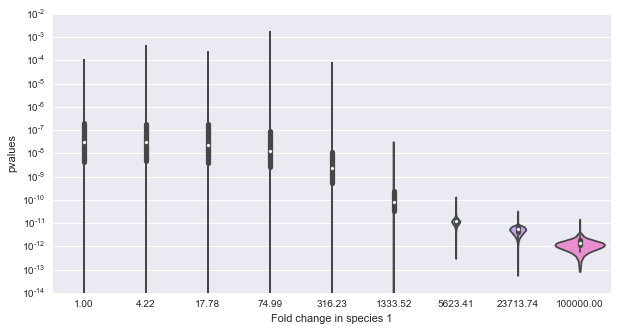

In [14]:
fig = plt.figure(figsize=(10, 5))
ax = sns.violinplot(pvals.T)

_ = ax.set_xticklabels(labels)
ax.set_yscale('log')
ax.set_ylabel('pvalues') 
ax.set_xlabel('Fold change in species 1')

Basically, these underdog species are virtually indistinguishable, especially when they have bloomed substantially.
Recall the example we used in the FAlse Positive scenario.  1 species that is 100000x larger than all of the other species has the same before as 10 species that are 10000x larger than all of the other species.

Let's do a similar trick here.  Before we had 1 species that was 1000x larger than everything else.  Now let's look at 100 species that are 10x larger than everything else.

In [15]:
D = 1000   # number of species
S = 10     # number of different samples
N = 10000  # sequencing depth
R = 30     # number of replicates
otu_ids = ["O%d"%i for i in range(D)]
sample_ids = ["S%d"%i for i in range(S)]
data = [[1000]*D]
for a in np.logspace(0, 5, S-1):
    data.append([1000*a] + [1000*10]*100  + [1000]*(D-101))
table = pd.DataFrame(data, columns=otu_ids, index=sample_ids)

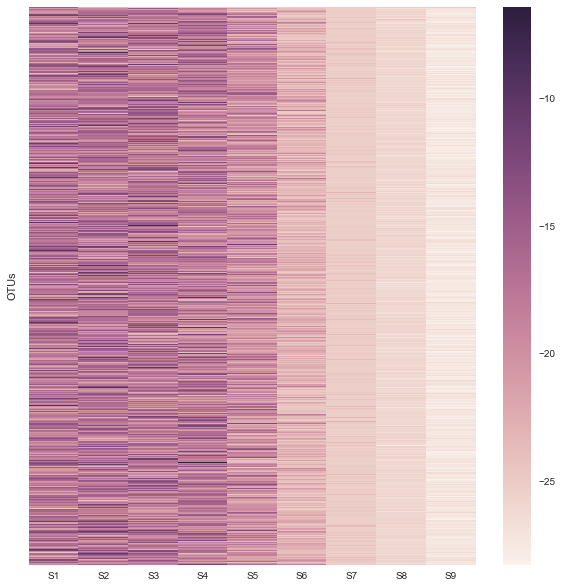

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = sns.heatmap(np.log(pvals.T))
_ = ax.set_yticklabels([])
ax.set_ylabel('OTUs')

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/seaborn/categorical.py:2296: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


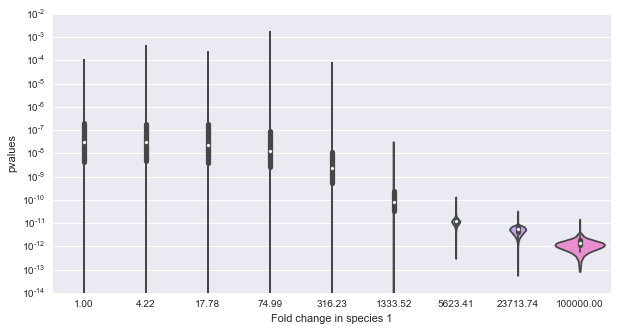

In [18]:
fig = plt.figure(figsize=(10, 5))
ax = sns.violinplot(pvals.T)
_ = ax.set_xticklabels(labels)
ax.set_yscale('log')
ax.set_ylabel('pvalues') 
ax.set_xlabel('Fold change in species 1')

And as you can see, even in this more nuanced scenario there is the same pattern as we have seen before.  

In summary, this notebook has shown that when standard univariate tools are applied to compositional data, it can lead to both false positives and false negatives.  This is because these univariate tests assume independence between features.  But this is not the case with compositional data, since we are ultimately dealing with probabilities.
Since probabilities add up to 1, they cannot be independent.